# HW4-2: model optimization using pycarat or optuna or other AutoML
1. Feature engineering
2. model selection (ensemble)
3. training hyperparameter optimization

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load and examine the dataset structure

In [57]:
# Load and examine the dataset structure
data_train = pd.read_csv('dataset/titanic/train.csv')
data_challenge = pd.read_csv('dataset/titanic/test.csv')
display(data_train.info())
display(data_train.describe())
display(data_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualize relationships between features and survival

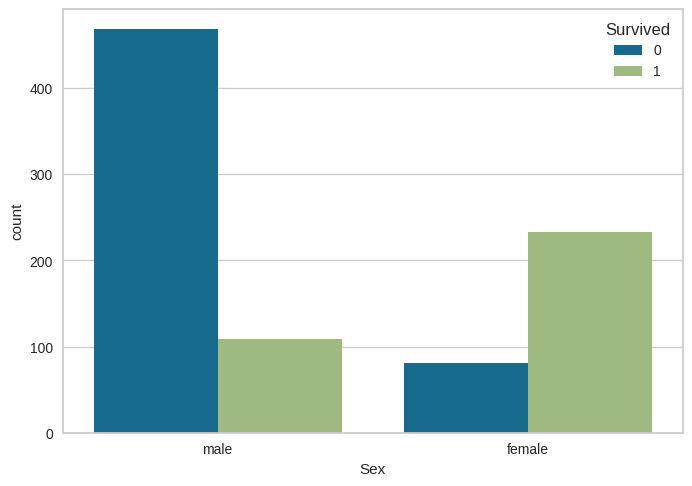

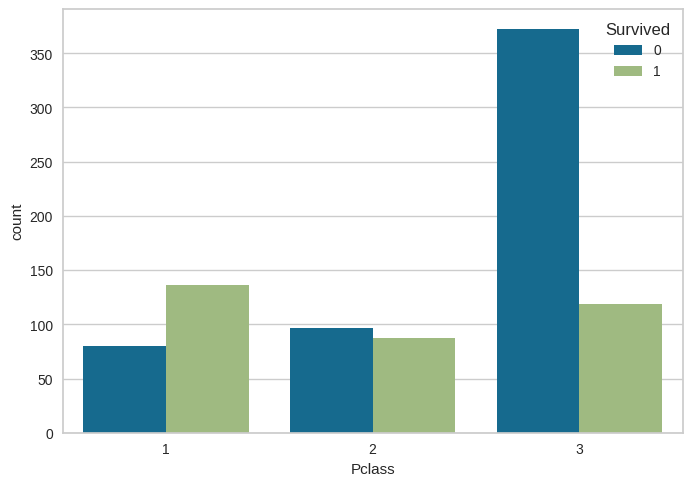

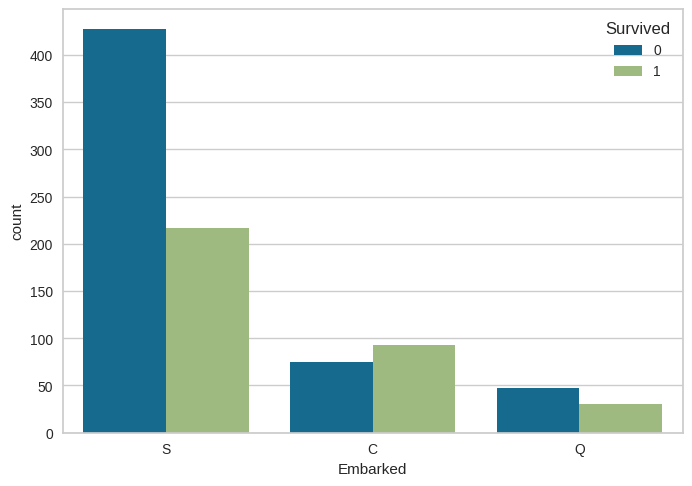

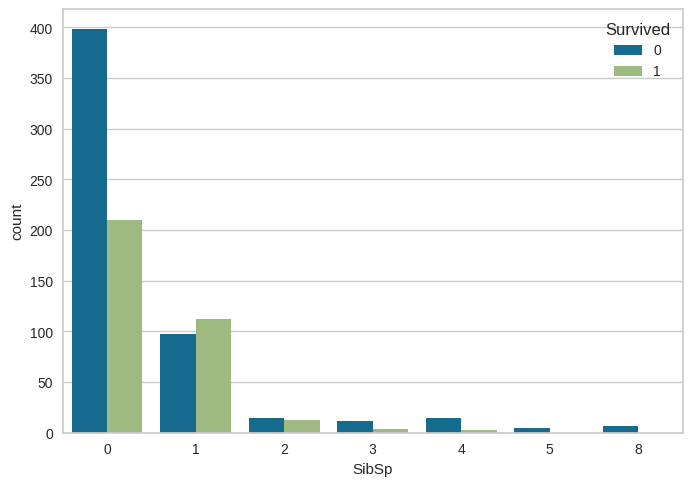

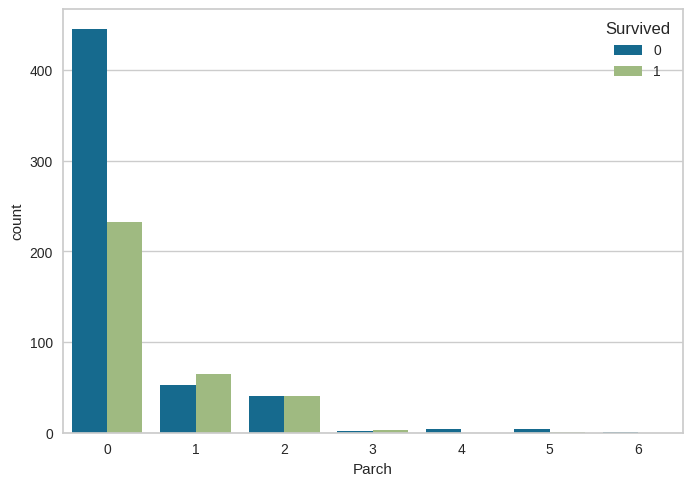

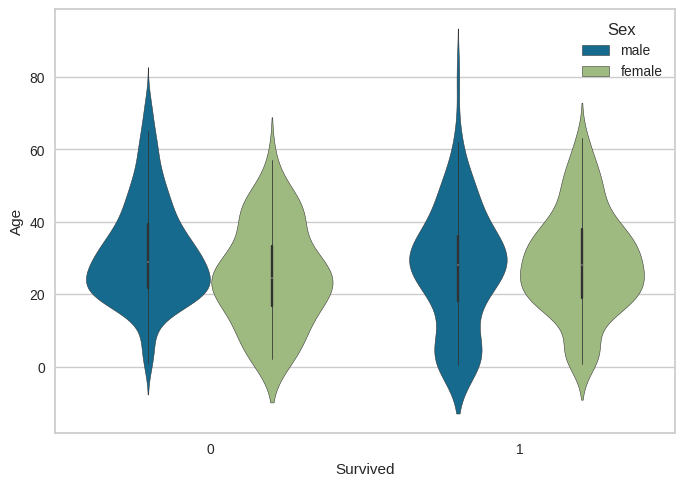

In [58]:
# sex vs survival
sns.countplot(data_train, x="Sex", hue="Survived")
plt.show()

# Pclass vs survival
sns.countplot(data_train, x="Pclass", hue="Survived")
plt.show()

# Embarked vs survival
sns.countplot(data_train, x="Embarked", hue="Survived")
plt.show()

# SibSp vs survival
sns.countplot(data_train, x="SibSp", hue="Survived")
plt.show()

# Parch vs survival
sns.countplot(data_train, x="Parch", hue="Survived")
plt.show()

# Age vs sex vs survival
sns.violinplot(x="Survived", y="Age", hue='Sex', data=data_train)
plt.show()

## Feature engineering

In [59]:
# family size
def processing_family_size(df):
    df['Fsize'] = df['SibSp'] + df['Parch'] + 1
    return df

# age
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

# cabin
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

# fare
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df 
    
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = drop_features(df)
    df = processing_family_size(df)
    return df

def fill_missing_values(df):
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    return df

# Handle missing values
data_train = fill_missing_values(data_train)
data_challenge = fill_missing_values(data_challenge)

# Transform features
data_train = transform_features(data_train)
data_challenge = transform_features(data_challenge)

## Visualize relationships between engineered features and survival

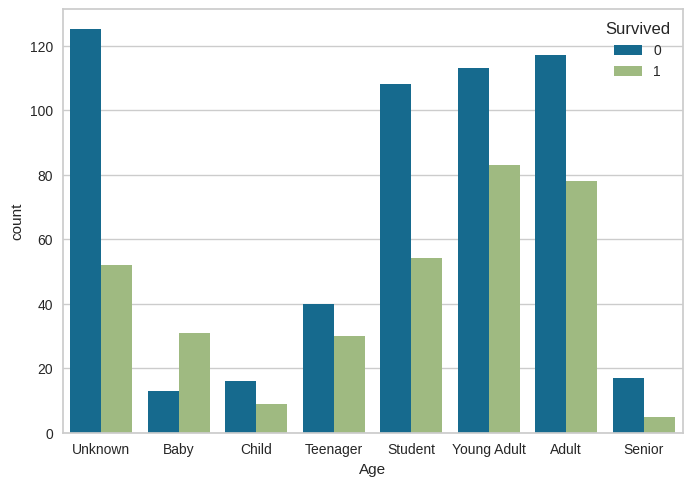

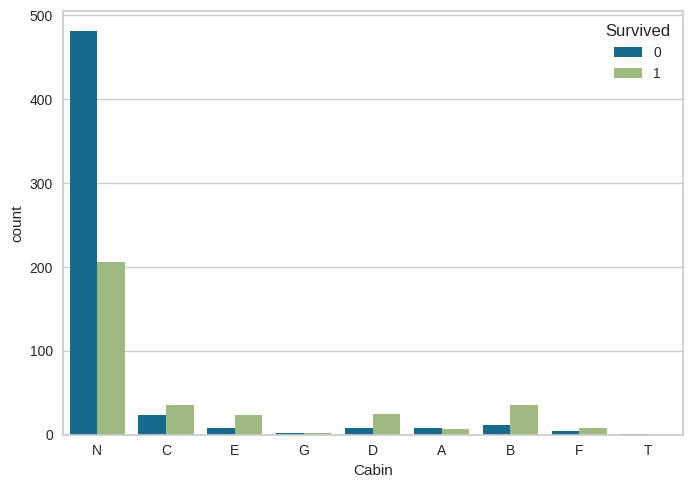

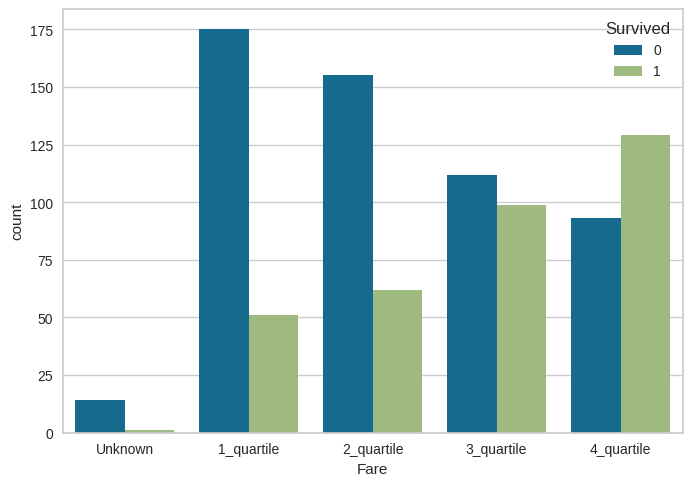

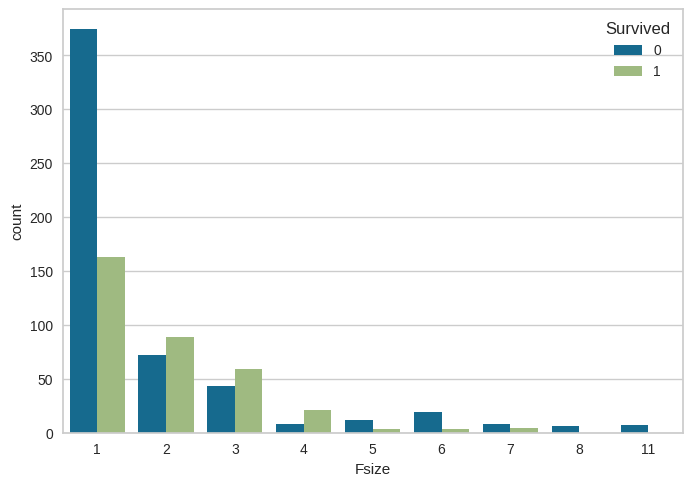

In [60]:
# age vs survival
sns.countplot(data_train, x="Age", hue="Survived")
plt.show()

# cabin vs survival
sns.countplot(data_train, x="Cabin", hue="Survived")
plt.show()

# fare vs survival
sns.countplot(data_train, x="Fare", hue="Survived")
plt.show()

# family size vs survival
sns.countplot(data_train, x="Fsize", hue="Survived")
plt.show()

## Data preparation

In [61]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data_train.drop(['PassengerId'],axis=1), random_state=42, train_size=0.8)


## Setup the PyCaret

In [24]:
clf1 = setup(
    data=data_train,
    target="Survived",
    categorical_features=["Pclass", "Sex", "Age", "Fare", "Cabin", "Embarked", "Fsize"],
)

,Description,Value
0,Session id,8296
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 10)"
4,Transformed data shape,"(891, 40)"
5,Transformed train set shape,"(623, 40)"
6,Transformed test set shape,"(268, 40)"
7,Numeric features,2
8,Categorical features,7
9,Preprocess,True


## Compare ML algorithm on classification problem 16 Models

In [25]:
compare_models(fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8298,0.8749,0.7240,0.8119,0.7642,0.6320,0.6356,0.4540
gbc,Gradient Boosting Classifier,0.8170,0.8706,0.7200,0.7844,0.7484,0.6057,0.6091,0.0440
xgboost,Extreme Gradient Boosting,0.8138,0.8509,0.7283,0.7732,0.7488,0.6014,0.6032,0.0360
lr,Logistic Regression,0.8105,0.8675,0.7447,0.7587,0.7493,0.5973,0.6001,0.4120
ridge,Ridge Classifier,0.8105,0.8694,0.7363,0.7627,0.7469,0.5959,0.5987,0.0280
lightgbm,Light Gradient Boosting Machine,0.8089,0.8623,0.7112,0.7738,0.7400,0.5895,0.5920,50.1020
svm,SVM - Linear Kernel,0.8057,0.8527,0.7368,0.7538,0.7418,0.5867,0.5903,0.0240
lda,Linear Discriminant Analysis,0.8041,0.8669,0.7279,0.7533,0.7380,0.5820,0.5848,0.0240
et,Extra Trees Classifier,0.8026,0.8195,0.7030,0.7635,0.7315,0.5759,0.5776,0.0460
rf,Random Forest Classifier,0.7977,0.8444,0.7031,0.7536,0.7258,0.5662,0.5685,0.0520


## Model Selection (ensemble)

In [ ]:
catboost = create_model('catboost')
gbc = create_model('gbc')
xgboost = create_model('xgboost')
lr = create_model('lr')
ridge = create_model('ridge')

stacker = stack_models(estimator_list = [catboost, gbc, xgboost, lr, ridge])
stacker

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8371,0.6667,0.8421,0.7442,0.6144,0.6240
1,0.8730,0.9151,0.8333,0.8333,0.8333,0.7308,0.7308
2,0.8095,0.8793,0.6667,0.8000,0.7273,0.5828,0.5885
3,0.7742,0.8239,0.5652,0.7647,0.6500,0.4888,0.5010
4,0.8548,0.8975,0.7917,0.8261,0.8085,0.6917,0.6921
5,0.8387,0.8964,0.7500,0.8182,0.7826,0.6548,0.6564
6,0.8226,0.8920,0.6667,0.8421,0.7442,0.6112,0.6209
7,0.8548,0.9446,0.8333,0.8000,0.8163,0.6964,0.6968
8,0.7419,0.8470,0.5417,0.7222,0.6190,0.4299,0.4401


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8205,0.6667,0.8000,0.7273,0.5828,0.5885
1,0.8730,0.9199,0.8333,0.8333,0.8333,0.7308,0.7308
2,0.7778,0.8536,0.6250,0.7500,0.6818,0.5132,0.5183
3,0.7903,0.8356,0.5652,0.8125,0.6667,0.5208,0.5391
4,0.8387,0.9035,0.7500,0.8182,0.7826,0.6548,0.6564
5,0.8065,0.8684,0.7500,0.7500,0.7500,0.5921,0.5921
6,0.8065,0.9052,0.7083,0.7727,0.7391,0.5857,0.5871
7,0.8548,0.9589,0.8750,0.7778,0.8235,0.7010,0.7045
8,0.7742,0.8602,0.5833,0.7778,0.6667,0.5011,0.5130


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8050,0.6667,0.8421,0.7442,0.6144,0.6240
1,0.8571,0.9343,0.8750,0.7778,0.8235,0.7042,0.7077
2,0.7937,0.8387,0.6667,0.7619,0.7111,0.5517,0.5547
3,0.7903,0.7865,0.6957,0.7273,0.7111,0.5467,0.5470
4,0.8548,0.8668,0.7917,0.8261,0.8085,0.6917,0.6921
5,0.8065,0.8887,0.8333,0.7143,0.7692,0.6043,0.6096
6,0.7742,0.8262,0.5417,0.8125,0.6500,0.4930,0.5151
7,0.8387,0.9435,0.8333,0.7692,0.8000,0.6652,0.6667
8,0.7581,0.7856,0.6250,0.7143,0.6667,0.4781,0.4807


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8307,0.6667,0.8000,0.7273,0.5828,0.5885
1,0.8889,0.9076,0.8333,0.8696,0.8511,0.7625,0.7630
2,0.8095,0.8643,0.6667,0.8000,0.7273,0.5828,0.5885
3,0.7903,0.8283,0.5652,0.8125,0.6667,0.5208,0.5391
4,0.8548,0.8920,0.7917,0.8261,0.8085,0.6917,0.6921
5,0.8226,0.8898,0.7500,0.7826,0.7660,0.6232,0.6236
6,0.8226,0.8953,0.6667,0.8421,0.7442,0.6112,0.6209
7,0.8387,0.9534,0.8750,0.7500,0.8077,0.6702,0.6761
8,0.7581,0.8459,0.5417,0.7647,0.6341,0.4612,0.4765


StackingClassifier(cv=5,
                   estimators=[('CatBoost Classifier',
                                <catboost.core.CatBoostClassifier object at 0x715079df67d0>),
                               ('Gradient Boosting Classifier',
                                GradientBoostingClassifier(ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.1,
                                                           loss='log_loss',
                                                           max_depth=3,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_samples_leaf=1...
                                              num_parallel_tree=None,
                                              objective='binary:logistic', ...))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=8296,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

## Save model

In [30]:
model_path = 'model/titanic_model'
save_model(stacker, model_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['SibSp', 'Parch'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Pclass', 'Sex', 'Age', 'Fare...
                                                                objective='binary:logistic', ...))],
                                     final_estimator=LogisticRegression(C=1.

## Predict on Test set

In [ ]:
model = load_model(model_path)
pred = predict_model(model, data=test_data)

Transformation Pipeline and Model Successfully Loaded


Accuracy: 0.8715083798882681


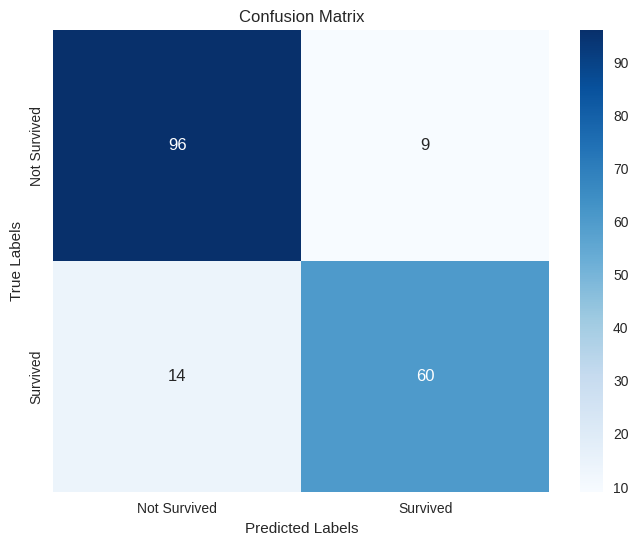

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       105
           1       0.87      0.81      0.84        74

    accuracy                           0.87       179
   macro avg       0.87      0.86      0.87       179
weighted avg       0.87      0.87      0.87       179



In [ ]:
y_test = test_data['Survived']
y_pred = pred['prediction_label']

print("Accuracy:", accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

## Predict on challenge set

In [62]:
pred = predict_model(model, data=data_challenge)


In [63]:
# Create a DataFrame with the results
submission = pd.DataFrame({
    'PassengerId': pred['PassengerId'],
    'Survived': pred['prediction_label']
})

# Export the results to a CSV file
submission.to_csv('submission.csv', index=False)